In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Utils import *
import numba as nb
from numba import njit

import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference import SNPE, SNLE, simulate_for_sbi 
from sbi import analysis as analysis

### 1. Load simulated data

In [63]:
# Load the simulated data
data = np.load('saved/sim/SBI_data_r1_15HT_newprior.npz')
#print("Data loaded")
data['theta'].shape

(150000, 8)

In [51]:
# check for nan values in theta
print(np.sum(data['theta'] == np.nan))
print(np.sum(data['theta'] == np.inf))

print(np.sum(data['x'] == np.nan))
print(np.sum(data['x'] == np.inf))

0
0
0
11


In [5]:
# CHECK ALL THE SIMULATED 

all_theta = []
all_x = []
for i in range(40):
     data = np.load(f'saved/mini_sim/SBI_data_r1_1HT_newprior_trial_{i}.npz')
     theta_shape = data['theta'].shape[0]
    
     if theta_shape != 2500:
          print("oh nooooo")
          print(f"corrupted file", i)
     #else:
        #print(f"file", i, "with", theta_shape)

In [4]:
# check for nan values in theta
print(np.sum(data['theta'] == np.nan))
print(np.sum(data['theta'] == np.inf))

print(np.sum(data['x'] == np.nan))
print(np.sum(data['x'] == np.inf))

0
0
0
11


In [52]:
# If the data is loaded but not simulated
# Convert from numpy to torch
theta_2 = torch.from_numpy(data['theta'])
x_2 = torch.from_numpy(data['x'])
x_2.shape

torch.Size([100000, 7])

In [7]:
# Range of values of theta
u = theta.unique()
u.max(), u.min()

(tensor(1.0000), tensor(3.8743e-06))

In [8]:
# Check for NaN values
print(torch.sum(torch.isnan(theta)))
print(torch.sum(torch.isinf(theta)))

# Check for NaN and Inf values in 'x'
print(torch.sum(torch.isnan(x)))
print(torch.sum(torch.isinf(x)))

tensor(0)
tensor(0)
tensor(0)
tensor(1)


### 2. Take S and B for training

In [6]:
# Take only S an B for trainingx
x = x[:,0:2]
x.shape

torch.Size([50000, 2])

### 2. Training

In [7]:
# Define the prior 
# number of parameters
num_dim = 8 # eta_e, eta_i

# Define priors 
prior = BoxUniform(low=-1 * torch.ones(num_dim), high=1 * torch.ones(num_dim))


#estimator = posterior_nn(model='nsf')
# instantiate the inference object
inference = SNPE(prior=prior)
# compute the inference
# ACHTUNG! need to change theta_filtered and x_filtered
inference = inference.append_simulations(theta, x)

In [8]:
inference

In [9]:
# train the neural density estimator
density_estimator = inference.train()

 Neural network successfully converged after 149 epochs.

In [13]:
# Generate the posterior
posterior = inference.build_posterior(density_estimator)

In [14]:
posterior

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

### 4. Study the posterior distribution on 0,0 observation 

In [14]:
# observation of S = 0 and B = 0
#observation = torch.zeros(1,2)
#observation

tensor([[0., 0.]])

In [15]:
# Sample from the posterior conditioned on the obsrvation 

#posterior_samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    9906 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


In [16]:
#posterior_samples.shape

torch.Size([10000, 8])

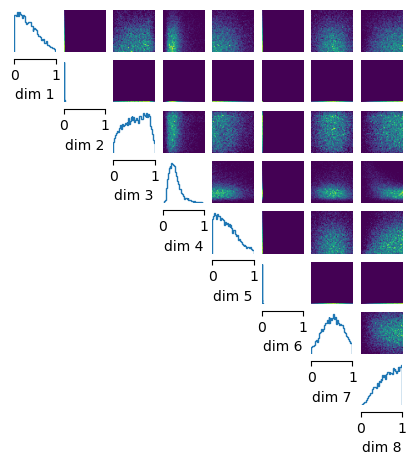

In [17]:
# plot posterior samples
#_ = analysis.pairplot(
#    posterior_samples, limits=[[0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1]], figsize=(5, 5)
#)

### 5. ROUND 2 INFERENCE: Posterior becomes proposal

In [15]:
def simulator_neuron(parameters):
    
    p = parameters.cpu().detach().numpy()
    # parameters.cpu().detach().numpy() converts a pytorch tensor into a numpy array 
    (S, B, D, A, mu, sigma, r_squared) = run_network_plasticity(p)
    
    return (S, B, D, A, mu, sigma, r_squared)

In [16]:
# observation of S = 0 and B = 0
observation = torch.zeros(1,2)
observation

tensor([[0., 0.]])

In [20]:
# Proposal - the samples from the posterior become the new prior (pi_2)
prior_2 =  posterior.set_default_x(observation)
prior_2

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [19]:
theta, x = simulate_for_sbi(simulator=simulator_neuron, proposal=prior_2, num_simulations=50000)

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

ValueError: unable to broadcast argument 5 to output array
File "/mnt/qb/work/wu/wkn661/evolving_plasticity/new/Utils.py", line 1, 

In [22]:
theta.shape, x.shape

(torch.Size([10000, 8]), torch.Size([10000, 2]))

In [ ]:
inference = SNPE(prior=prior_2)


inference = inference.append_simulations(theta, x)

# train the neural density estimator
density_estimator = inference.train()

# Generate the posterior
posterior_2 = inference.build_posterior(density_estimator)